# Import Libraries

In [8]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os

# Data Preprocessing

In [9]:
ROOT = "./datasets/"
SEED = 88
IMG_SIZE = (224, 224)    # load at original size first
BATCH_SIZE = 256
LABEL_MODE = "categorical" # one‑hot labels straight away

classes=["broccoli", "cauliflower", "unknown"]
splits=["test", "train", "validate"]

def load_split(split):
    dataset=tf.keras.preprocessing.image_dataset_from_directory(ROOT+split,
        seed        = SEED,
        image_size  = IMG_SIZE,
        batch_size  = BATCH_SIZE,
        label_mode  = LABEL_MODE)
    return dataset

train_ds_pre = load_split("train")
val_ds_pre = load_split("validate")
test_ds_pre = load_split("test")

Found 4149 files belonging to 3 classes.
Found 521 files belonging to 3 classes.
Found 521 files belonging to 3 classes.


,broccoli,cauliflower,unknown
test,247,236,38
train,1975,1879,295
validate,247,236,38


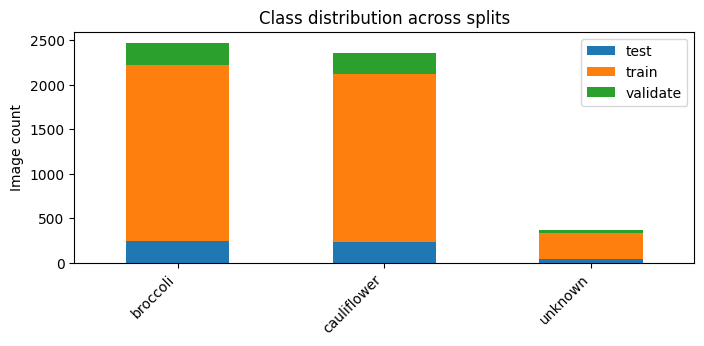

In [10]:
def count_images(split):
    return {cls: len(os.listdir(f"{ROOT}{split}/{cls}/"))
            for cls in classes}

df_counts = pd.DataFrame({s: count_images(s) for s in splits})

display(df_counts.T)  # nice Jupyter table
ax = df_counts.plot.bar(stacked=True, figsize=(8,3))
ax.set_title("Class distribution across splits")
ax.set_ylabel("Image count")
plt.xticks(rotation=45, ha="right")
plt.show()

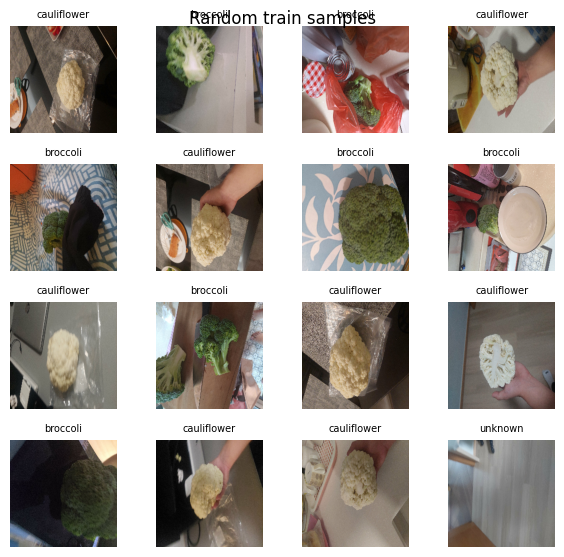

In [11]:
plt.figure(figsize=(6,6))
for images, labels in train_ds_pre.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])], fontsize=7)
        plt.axis("off")
plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

In [12]:
TARGET_SIZE = 100

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(TARGET_SIZE, TARGET_SIZE),
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom(0.2),
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
                num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds_pre, shuffle=True, augment=True)
val_ds = prepare(val_ds_pre)
test_ds = prepare(test_ds_pre)

In [ ]:
plt.figure(figsize=(3,3))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        plt.title(classes[np.argmax(labels[i])], fontsize=7)
        plt.axis("off")

plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

In [ ]:
num_classes = 3

model = keras.Sequential()

model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(TARGET_SIZE, TARGET_SIZE,3)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),strides =1))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten(input_shape=(TARGET_SIZE, TARGET_SIZE,3)))

model.add(Dense(16, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Optimizer = optimizers.Adam(0.001)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Optimizer,
              metrics=['accuracy'])


In [ ]:
history = model.fit(
    train_ds,
    epochs=20,
    verbose=1,
    validation_data = train_ds
)

score = model.evaluate(test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

tf.keras.models.save_model(model,'my_model.hdf5')

In [ ]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()